In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import seaborn as sns

In [2]:
def rename_colums(df, add_name):
    df.rename(columns = {'anger':'anger'+add_name, 'disgust':'disgust'+add_name, 'fear':'fear'+add_name,'neutral':'neutral'+add_name,'joy':'joy'+add_name,'surprise':'surprise'+add_name, 'sadness':'sadness'+add_name}, inplace = True)

In [3]:
def get_dataframe(path, add_name):
    df = pd.read_csv(path)
    rename_colums(df, add_name)
    return df

In [4]:
def name_to_string(df):
    df['name'] = df['name'].astype(str)

In [5]:
def change_name(name): #функция возвращает таргет для словаря признаков
    data = name.split('_')

    dia = int(data[0][3:])
    utt = int(data[1][3:])

    return 'dia'+str(utt)+'_'+'utt'+str(dia)

In [6]:
def return_y(df, data_y, y):
    for i in range(len(df)):
        data = df.loc[i, 'name'].split('_')
        dia = int(data[0][3:])
        utt = int(data[1][3:])
        for j in range(len(data_y)):
            if  dia==data_y.loc[j, 'Dialogue_ID'] and utt ==data_y.loc[j, 'Utterance_ID']:
                y.loc[i, 'Emotion'] = data_y.loc[j, 'Emotion']
                break

In [7]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [8]:
def compute_uar(confusion_matrix):
    cm = confusion_matrix
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sum = 0
    for i in range(7):
        sum += cmn[i, i]
    uar = sum/7
    return uar

In [9]:
path = 'train_sent_emo.csv'
train = pd.read_csv(path)
path = 'test_sent_emo.csv'
test = pd.read_csv(path)
dev = pd.read_csv('dev_sent_emo_replaced.csv')

In [10]:
train.drop(columns=['Sr No.', 'Utterance', 'Speaker', 'Season', 'Episode', 'StartTime', 'EndTime', 'Sentiment'], axis=1, inplace=True)
test.drop(columns=['Sr No.', 'Utterance', 'Speaker', 'Season', 'Episode', 'StartTime', 'EndTime', 'Sentiment'], axis=1, inplace=True)
dev.drop(columns=['Sr No.', 'Utterance', 'Speaker', 'Season', 'Episode', 'StartTime', 'EndTime', 'Sentiment'], axis=1, inplace=True)

In [11]:
text_train_predictions = get_dataframe('probs_text_train.csv', '_t')
text_test_predictions = get_dataframe('probs_text_test.csv', '_t')
text_dev_predictions = get_dataframe('probs_text_dev.csv', '_t')

audio_train_predictions = get_dataframe('probs_audio_train.csv', '_a')
audio_test_predictions = get_dataframe('probs_audio_test.csv', '_a')
audio_dev_predictions = get_dataframe('probs_audio_dev.csv', '_a')

video_train_predictions = get_dataframe('train_probs2.csv', '_v')
video_test_predictions = get_dataframe('test_probs.csv', '_v')
video_dev_predictions = get_dataframe('dev_probs.csv', '_v')

In [12]:
audio_train_predictions.drop(columns=['targets'], axis=1, inplace=True)
text_train_predictions.drop(columns=['targets'], axis=1, inplace=True)
audio_test_predictions.drop(columns=['targets'], axis=1, inplace=True)
text_test_predictions.drop(columns=['targets'], axis=1, inplace=True)
text_dev_predictions.drop(columns=['targets'], axis=1, inplace=True)
audio_dev_predictions.drop(columns=['targets'], axis=1, inplace=True)

In [13]:
name_to_string(text_train_predictions)
name_to_string(audio_train_predictions)
name_to_string(video_train_predictions)

In [14]:
train_df = text_train_predictions.copy()
train_df = train_df.merge(audio_train_predictions, on='name', how='inner')
train_df = train_df.merge(video_train_predictions, on='name', how='inner')

In [15]:
y_train = []
y_train = pd.DataFrame(y_train)
return_y(train_df, train, y_train)
y_train

,Emotion
0,neutral
1,neutral
2,neutral
3,neutral
4,surprise
...,...
9984,neutral
9985,neutral
9986,surprise
9987,neutral


In [16]:
labels_train = y_train.copy()
labels_train = labels_train.values.ravel()
names = train_df['name'].copy()
train_df.drop(columns=['name'], axis=1, inplace=True)

In [16]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=1000),
    #MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=1000),
    CatBoostClassifier(),
    LGBMClassifier(),
  #  XGBClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, train_df, labels_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.6609672	total: 163ms	remaining: 2m 42s
1:	learn: 1.4818582	total: 175ms	remaining: 1m 27s
2:	learn: 1.3301424	total: 186ms	remaining: 1m 1s
3:	learn: 1.2212208	total: 199ms	remaining: 49.6s
4:	learn: 1.1297413	total: 214ms	remaining: 42.5s
5:	learn: 1.0603586	total: 231ms	remaining: 38.2s
6:	learn: 0.9903426	total: 245ms	remaining: 34.7s
7:	learn: 0.9364066	total: 260ms	remaining: 32.3s
8:	learn: 0.8878759	total: 275ms	remaining: 30.2s
9:	learn: 0.8431871	total: 288ms	remaining: 28.5s
10:	learn: 0.8006060	total: 301ms	remaining: 27.1s
11:	learn: 0.7658235	total: 315ms	remaining: 26s
12:	learn: 0.7353926	total: 329ms	remaining: 24.9s
13:	learn: 0.7094714	total: 343ms	remaining: 24.1s
14:	learn: 0.6820961	total: 356ms	remaining: 23.4s
15:	learn: 0.6590004	total: 370ms	remaining: 22.8s
16:	learn: 0.6389476	total: 391ms	remaining: 22.6s
17:	learn: 0.6226231	total: 410ms	remaining: 22.4s
18:	learn: 0.6047427	total: 428ms	remaining: 22.1s
19:	learn: 

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1,
                ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.880167,0.011947
LGBMClassifier,0.877765,0.012297
LinearSVC,0.867954,0.014246
LogisticRegression,0.856842,0.013873
RandomForestClassifier,0.839223,0.017254


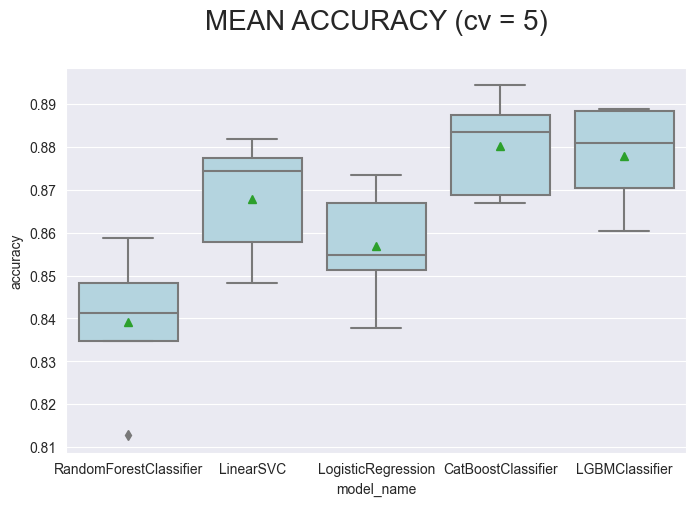

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [20]:
test_df = text_test_predictions.copy()
test_df = test_df.merge(audio_test_predictions, on='name', how='inner')
test_df = test_df.merge(video_test_predictions, on='name', how='inner')

In [21]:
y_test = []
y_test = pd.DataFrame(y_test)
return_y(test_df, test, y_test)
y_test

,Emotion
0,surprise
1,anger
2,neutral
3,neutral
4,joy
...,...
2605,neutral
2606,surprise
2607,neutral
2608,neutral


In [22]:
labels = y_test.copy()
labels = labels.values.ravel()
test_df.drop(columns=['name'], axis=1, inplace=True)

In [58]:
clf = LinearSVC(C=xx, random_state=x, class_weight='balanced', max_iter=x).fit(train_df, labels_train)

In [59]:
y_pred = clf.predict(test_df)

In [25]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       anger       0.47      0.51      0.49       345
     disgust       0.15      0.04      0.07        68
        fear       0.18      0.04      0.07        50
         joy       0.56      0.61      0.58       402
     neutral       0.78      0.79      0.78      1256
     sadness       0.36      0.29      0.32       208
    surprise       0.55      0.62      0.58       281

    accuracy                           0.63      2610
   macro avg       0.43      0.41      0.41      2610
weighted avg       0.62      0.63      0.62      2610



In [26]:
cm = confusion_matrix(y_test, y_pred)
compute_uar(cm)

0.41386215524453995

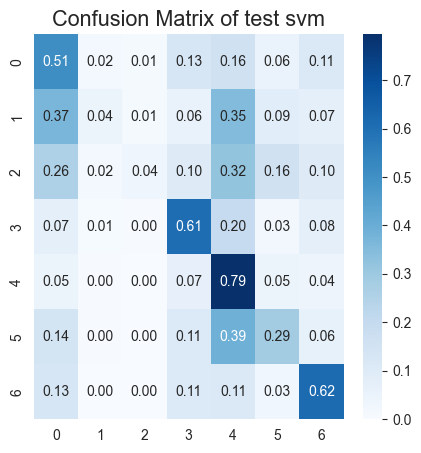

In [27]:
cm_plot(y_test, y_pred, 'test svm')